In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
df = pd.read_csv("combined_energy_data.csv")

In [7]:
wind_columns = [ 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']
wind_angle_columns = ['guitrancourt_Direction (deg N)','lieusaint_Direction (deg N)','lvs-pussay_Direction (deg N)',
 'parc-du-gatinais_Direction (deg N)','arville_Direction (deg N)','boissy-la-riviere_Direction (deg N)','angerville-1_Direction (deg N)', 
 'angerville-2_Direction (deg N)','guitrancourt-b_Direction (deg N)','lieusaint-b_Direction (deg N)','lvs-pussay-b_Direction (deg N)',
 'parc-du-gatinais-b_Direction (deg N)','arville-b_Direction (deg N)','boissy-la-riviere-b_Direction (deg N)','angerville-1-b_Direction (deg N)','angerville-2-b_Direction (deg N)'

]

In [8]:
wind_speed_columns = set(wind_columns) - set(angle_columns)
wind_speed_columns = list(wind_speed_columns)

NameError: name 'angle_columns' is not defined

## Data Preprocessing

In [9]:
## convert it to datetime
df['datetime'] = pd.to_datetime(df.datetime)

In [10]:
agg_columns =  ["datetime","Wind"]
required_columns = ["Hours"] + agg_columns + [i for i in df.columns[12:]]

In [11]:
#the
df.datetime.min() , df.datetime.max()

(Timestamp('2016-12-31 23:00:00'), Timestamp('2020-07-16 21:45:00'))

In [12]:
df_agg = df[agg_columns].groupby([df.datetime.dt.floor("H")]).agg(["mean","median","max","min","std","sum"])

In [13]:
df_agg.columns = df_agg.columns.map('_'.join)

In [14]:
df_agg = df_agg.reset_index()

In [15]:
df_agg.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Wind_sum
0,2016-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_merged = df_agg.merge(df[required_columns], how="left", on="datetime")

In [17]:
df_merged.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Wind_sum,Hours,Wind,guitrancourt_Speed(m/s),...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,2016-12-31 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,00:00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,01:00,0.0,1.86,...,2.51,225.0,2.52,225.0,2.73,226.0,2.74,228.0,2.74,228.0
2,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,02:00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,03:00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,04:00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_interpolated = df_merged.interpolate(method="linear")

In [19]:
df_interpolated = df_interpolated[2:]

In [20]:
df_interpolated = df_interpolated.reset_index(drop=True)

In [21]:
df_interpolated.head()

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Wind_sum,Hours,Wind,guitrancourt_Speed(m/s),...,parc-du-gatinais-b_Speed(m/s),parc-du-gatinais-b_Direction (deg N),arville-b_Speed(m/s),arville-b_Direction (deg N),boissy-la-riviere-b_Speed(m/s),boissy-la-riviere-b_Direction (deg N),angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N)
0,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,02:00,0.0,1.961667,...,2.505,221.333333,2.516667,221.333333,2.723333,221.833333,2.72,223.5,2.72,223.5
1,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,03:00,0.0,2.063333,...,2.500,217.666667,2.513333,217.666667,2.716667,217.666667,2.70,219.0,2.70,219.0
2,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,04:00,0.0,2.165000,...,2.495,214.000000,2.510000,214.000000,2.710000,213.500000,2.68,214.5,2.68,214.5
3,2017-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,05:00,0.0,2.266667,...,2.490,210.333333,2.506667,210.333333,2.703333,209.333333,2.66,210.0,2.66,210.0
4,2017-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,06:00,0.0,2.368333,...,2.485,206.666667,2.503333,206.666667,2.696667,205.166667,2.64,205.5,2.64,205.5


# STOP

# STOP

In [858]:
## sin/cos operations

In [859]:
sin_angle = np.sin(df_interpolated[wind_angle_columns].copy())
cos_angle = np.cos(df_interpolated[wind_angle_columns].copy())

In [860]:
def create_wind_and_angle_product_dataframe(angle_frame,angle_operation="sin"):
    product = np.array([df_interpolated[wind_speed_columns[i]] * angle_frame.iloc[:,i]  for i in range(len(wind_speed_columns))]).T
    df = pd.DataFrame(product)
    df.columns =  wind_speed_columns 
    df.columns = angle_operation+ " " +  df.columns
    return df

In [133]:
df_sin = create_wind_and_angle_product_dataframe(sin_angle,"sin")
df_cos = create_wind_and_angle_product_dataframe(cos_angle,"cos")

In [134]:
df_interpolated = df_interpolated.merge(df_sin,on=df_interpolated.index,how="left").iloc[:,1:]
df_interpolated = df_interpolated.merge(df_cos,on=df_interpolated.index,how="left").iloc[:,1:]

## Feature selections through AR and PAR

In [135]:
import matplotlib.pyplot as plt
import seaborn as snn

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [136]:
## plot AR
def plot_auto_regression(data):
    fig , axs = plt.subplots(1,2,figsize=(20,8))
    lags = [30*24,90*24]

    for ax, lag in zip(axs.flatten(),lags):
        plot_acf(data,ax=ax, lags=lag)
    plt.plot()


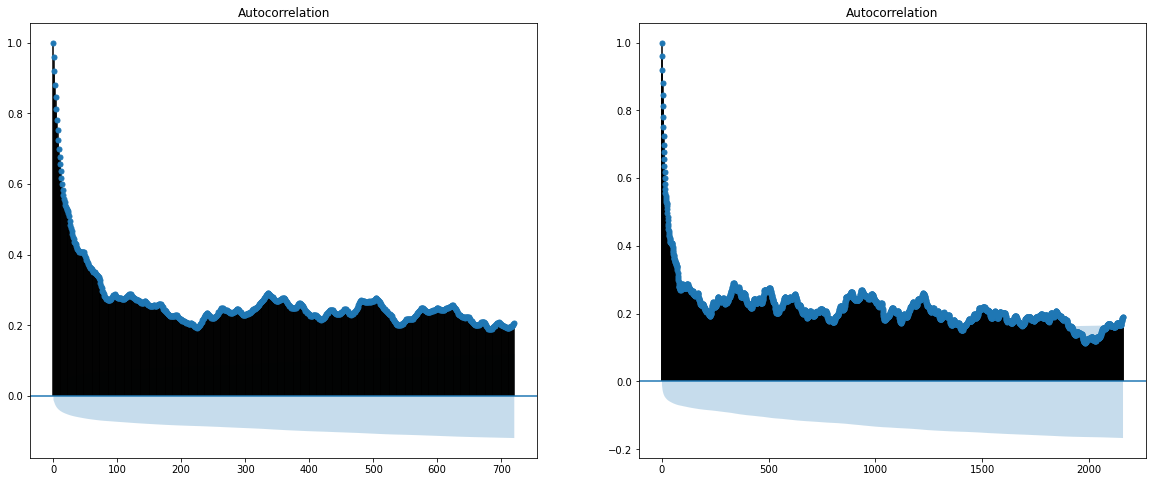

In [137]:
plot_auto_regression(df_interpolated.Wind)

In [138]:
hours_list = ["0{}:00".format(i)  for i in range(10)] + ["{}:00".format(i)  for i in range(10,25)]

In [139]:
useful_columns = df_interpolated.columns[1:]
print(useful_columns[:10])

Index(['Wind_mean', 'Wind_median', 'Wind_max', 'Wind_min', 'Wind_std', 'Hours',
       'Wind', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)'],
      dtype='object')


In [140]:
print(useful_columns[10:20])

Index(['lieusaint_Direction (deg N)', 'lvs-pussay_Speed(m/s)',
       'lvs-pussay_Direction (deg N)', 'parc-du-gatinais_Speed(m/s)',
       'parc-du-gatinais_Direction (deg N)', 'arville_Speed(m/s)',
       'arville_Direction (deg N)', 'boissy-la-riviere_Speed(m/s)',
       'boissy-la-riviere_Direction (deg N)', 'angerville-1_Speed(m/s)'],
      dtype='object')


In [141]:
print(useful_columns[20:30])

Index(['angerville-1_Direction (deg N)', 'angerville-2_Speed(m/s)',
       'angerville-2_Direction (deg N)', 'guitrancourt-b_Speed(m/s)',
       'guitrancourt-b_Direction (deg N)', 'lieusaint-b_Speed(m/s)',
       'lieusaint-b_Direction (deg N)', 'lvs-pussay-b_Speed(m/s)',
       'lvs-pussay-b_Direction (deg N)', 'parc-du-gatinais-b_Speed(m/s)'],
      dtype='object')


In [142]:
print(useful_columns[30:])

Index(['parc-du-gatinais-b_Direction (deg N)', 'arville-b_Speed(m/s)',
       'arville-b_Direction (deg N)', 'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)', 'sin lvs-pussay-b_Speed(m/s)',
       'sin arville_Speed(m/s)', 'sin lieusaint-b_Speed(m/s)',
       'sin angerville-2_Speed(m/s)', 'sin parc-du-gatinais_Speed(m/s)',
       'sin boissy-la-riviere-b_Speed(m/s)', 'sin lieusaint_Speed(m/s)',
       'sin boissy-la-riviere_Speed(m/s)', 'sin angerville-1_Speed(m/s)',
       'sin guitrancourt-b_Speed(m/s)', 'sin lvs-pussay_Speed(m/s)',
       'sin guitrancourt_Speed(m/s)', 'sin angerville-1-b_Speed(m/s)',
       'sin arville-b_Speed(m/s)', 'sin parc-du-gatinais-b_Speed(m/s)',
       'sin angerville-2-b_Speed(m/s)', 'cos lvs-pussay-b_Speed(m/s)',
       'cos arville_Speed(m/s)', 'cos lieusaint-b_Speed(m/s)',
     

In [173]:
def plot_all_acf(column_name,pruned_lag=0):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))

    for hour, ax in zip(hours_list, axs.flatten()):
            plot_acf(df_interpolated[[column_name,"Hours"]][df.Hours==hour][column_name].dropna(), ax=ax, lags=60)
            ax.set_title('Autocorrelation hour {} with {}'.format(str(hour), column_name) )
            ax.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
            #ax.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
    plt.plot()
    
def plot_all_pacf(column_name,pruned_lag=0):
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))
    
    for hour, ax in zip(hours_list, axs.flatten()):
            plot_pacf(df_interpolated[[column_name,"Hours"]][df.Hours==hour][column_name].dropna(), ax=ax, lags=60)
            ax.set_title('Autocorrelation hour {} with {}'.format(str(hour), column_name) )
            #ax.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
    plt.plot()


In [383]:
normalized_df_wind_mean[:]

0       -0.916810
1       -0.916810
2       -0.916810
3       -0.916810
4       -0.916810
           ...   
31010   -0.551194
31011   -0.551194
31012   -0.551194
31013   -0.551194
31014   -0.551194
Name: Wind_mean, Length: 31015, dtype: float64

In [462]:
normalized_df_wind_mean = (df_interpolated["Wind_mean"]-df_interpolated["Wind_mean"].mean())/(df_interpolated["Wind_mean"].std())
def plot_diff_day_but_same_hour_ccf(column_name,pruned_lag=0):
    
    fig, axs = plt.subplots(int(12), 2, figsize=(15, 2*50))
    col_val = df_interpolated[column_name].dropna()
    normalized_df_column = (col_val-col_val.mean())/col_val.std()
    this_normalized_df_wind_mean = normalized_df_wind_mean
    if (pruned_lag != 0):
        
        this_normalized_df_wind_mean = this_normalized_df_wind_mean[:-(pruned_lag)]
    print(this_normalized_df_wind_mean.shape)
    print(normalized_df_column.shape)
   
    for hour, ax in zip(hours_list, axs.flatten()):
            ax.xcorr(pd.Series(this_normalized_df_wind_mean)[df_interpolated.Hours==hour], pd.Series(normalized_df_column)[df_interpolated.Hours==hour], usevlines=True, maxlags=60, normed=True, lw=2 )
            ax.set_title('Cross-correlation hour {} with {}'.format(str(hour), column_name) )
            ax.grid(True)
            ax.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
            ax.plot(np.full(100,-2),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
            ax.plot(np.full(100,15),np.linspace(-0.1,0.9,100), 'go--', linewidth=1, markersize=1, color="green")
           
    plt.plot()

def plot_continuous_hour_ccf(column_name,pruned_lag=0):
   
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    col_val = df_interpolated[column_name].dropna()
    normalized_df_column = (col_val-col_val.mean())/col_val.std()
    this_normalized_df_wind_mean = normalized_df_wind_mean
    if (pruned_lag != 0):
        normalized_df_column = normalized_df_column
        this_normalized_df_wind_mean = this_normalized_df_wind_mean[:-(pruned_lag)]
   
    ax.xcorr(pd.Series(this_normalized_df_wind_mean), pd.Series(normalized_df_column), usevlines=True, maxlags=60, normed=True, lw=2 )
    ax.set_title('Cross-correlation with {}'.format( column_name) )
    ax.grid(True)
    plt.plot()
    plt.plot(np.linspace(-60,60,120),np.full(120,0.05), 'go--', linewidth=1, markersize=1, color="red")
    plt.plot(np.linspace(-60,60,120),np.full(120,-0.05), 'go--', linewidth=1, markersize=1, color="red")
    plt.plot(np.full(100,-30),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="blue")
    #plt.plot(np.full(100,18),np.linspace(-0.1,0.1,100), 'go--', linewidth=1, markersize=1, color="orange")
  

In [421]:
normalized_df_wind_mean[:-1]

0       -0.916810
1       -0.916810
2       -0.916810
3       -0.916810
4       -0.916810
           ...   
31010   -0.551194
31011   -0.551194
31012   -0.551194
31013   -0.551194
31014   -0.551194
Name: Wind_mean, Length: 31015, dtype: float64

In [422]:
def plot_diff_day_but_protect_eye(column_name,pruned_lag=0):
    
    subtitle_name = (['Cross-correlation hour {} with {}'.format(str(hour), column_name)  for hour in hours_list])
   
    
    col_val = df_interpolated[column_name].dropna()
    normalized_df_column = (col_val-col_val.mean())/col_val.std()
    this_normalized_df_wind_mean = normalized_df_wind_mean
    if (pruned_lag != 0):
        normalized_df_column = normalized_df_column
        this_normalized_df_wind_mean = this_normalized_df_wind_mean[:-(pruned_lag)]
    
    fig = make_subplots(rows=24, cols=1 , subplot_titles=subtitle_name)
    for hour, i in zip(hours_list,range(1,25)):
        cross_correlation = np.correlate(pd.Series(this_normalized_df_wind_mean)[df_interpolated.Hours==hour], pd.Series(normalized_df_column)[df_interpolated.Hours==hour],"full")
        cross_shape = int(cross_correlation.shape[0]/2)
        
        y = cross_correlation[cross_shape-60:cross_shape+60]/len(df_interpolated[column_name])
       
       
        
        
        fig.add_trace(go.Scatter(x=np.linspace(-60,60,120,dtype=np.int), y=y,mode="lines"),row=i, col=1)
        fig.add_trace(go.Scatter(x=np.linspace(-60,60,120), y=np.full(120,0.05), mode='lines'),row=i, col=1)
        fig.add_trace(go.Scatter(x=np.linspace(-60,60,120), y=np.full(120,-0.05), mode='lines'),row=i, col=1)
        fig.add_trace(go.Scatter(x=np.full(100,-2), y=np.linspace(-0.1,0.1,100), mode='lines'),row=i, col=1)
        fig.update_layout(height=9000, width=700,
                  title_text="Multiple Subplots with Different days but same hour")
        #print(i)
    fig.show()
            
 
    
def plot_continuous_hour_ccf_protect_eye(column_name,pruned_lag=0):

    col_val = df_interpolated[column_name].dropna()
    normalized_df_column = (col_val-col_val.mean())/col_val.std()
    this_normalized_df_wind_mean = normalized_df_wind_mean
    if (pruned_lag != 0):
        normalized_df_column = normalized_df_column
        this_normalized_df_wind_mean = this_normalized_df_wind_mean[:-(pruned_lag)]
    cross_correlation = np.correlate(pd.Series(this_normalized_df_wind_mean), pd.Series(normalized_df_column),"full")/len(df_interpolated[column_name])
    cross_shape = int(cross_correlation.shape[0]/2)
    print(cross_shape)
    y = cross_correlation[cross_shape-60:cross_shape+60]
    
    fig = px.line(x=np.linspace(-60,60,120,dtype=np.int), y=y)
    
    
    fig.add_scatter(x=np.linspace(-60,60,120), y=np.full(120,0.05), mode='lines')
    fig.add_scatter(x=np.linspace(-60,60,120), y=np.full(120,-0.05), mode='lines')
    fig.add_scatter(x=np.full(100,-30), y=np.linspace(-0.1,0.1,100), mode='lines')
   
    
    fig.layout.update(go.Layout(barmode = 'overlay',))

    #plotly.offline.plot(fig)
    fig.show()
    
    return cross_correlation
   

In [423]:
df_interpolated["Wind_mean_lag_year"] = df_interpolated["Wind_mean"].shift(-365)

In [424]:
plot_diff_day_but_protect_eye("Wind_mean_lag_year",365)

(30651,)
(30651,)


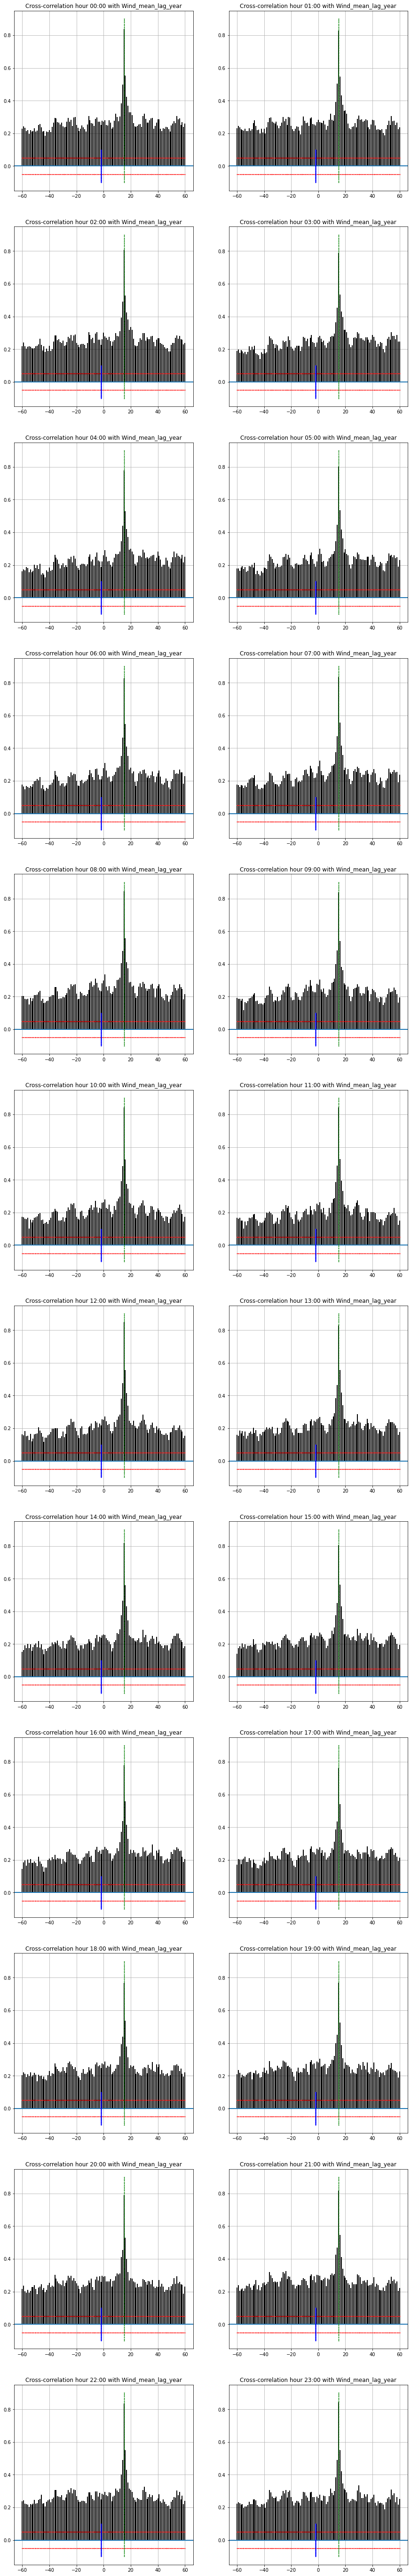

In [470]:
plot_diff_day_but_same_hour_ccf("Wind_mean_lag_year",365)

(31016,)
(31016,)


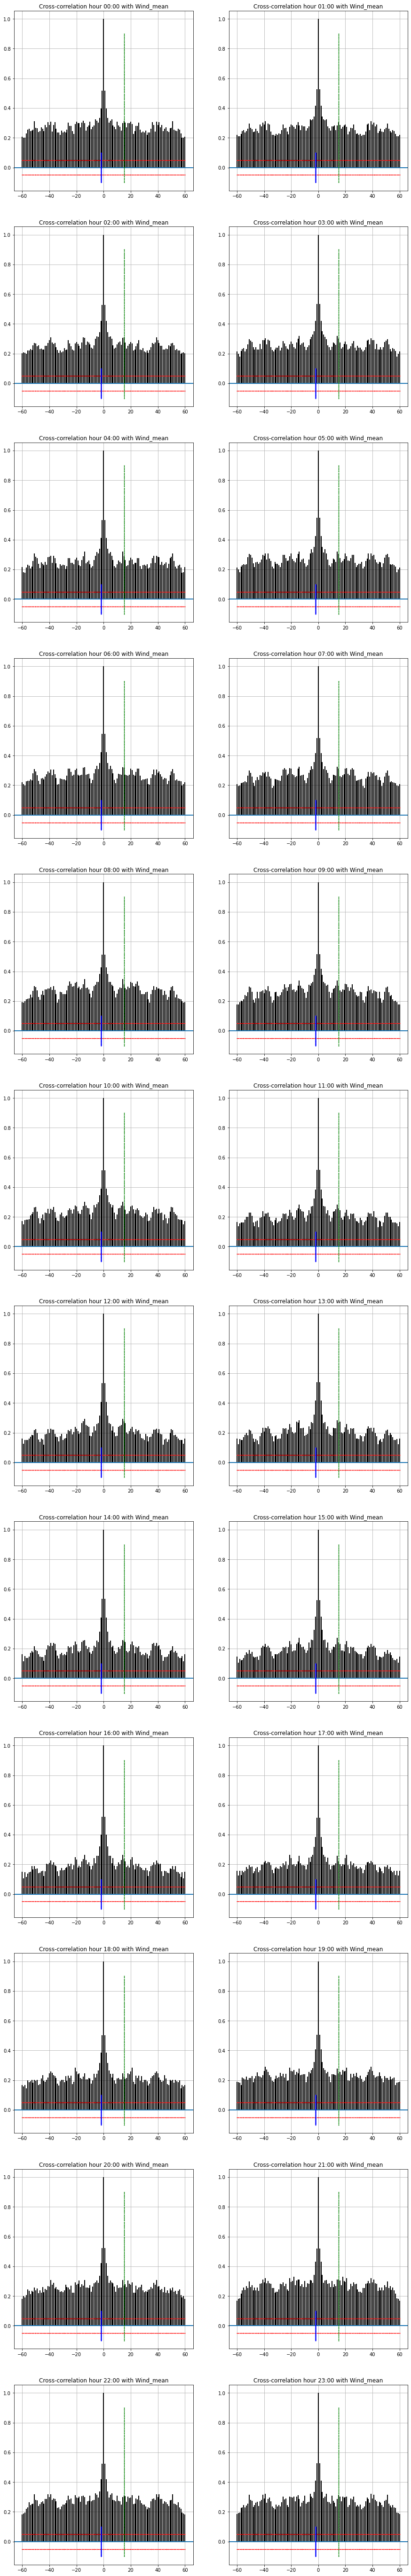

In [471]:
plot_diff_day_but_same_hour_ccf("Wind_mean")

(30998,)
(30998,)


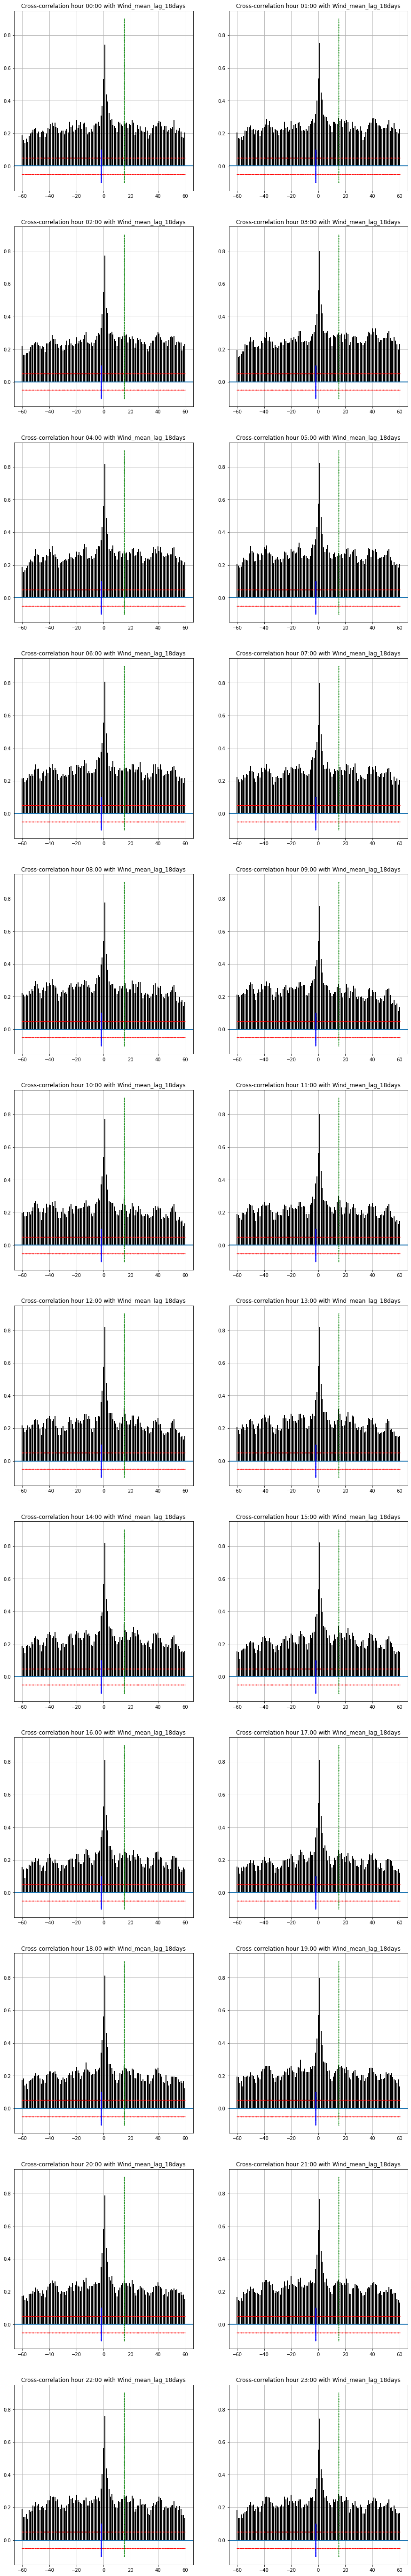

In [472]:
plot_diff_day_but_same_hour_ccf("Wind_mean_lag_18days",18)

In [652]:
def get_mse(i):
    return mean_squared_error(df_interpolated["Wind_mean"][:-i],df_interpolated["Wind_mean"].shift(-i).dropna())
def get_mae(i):
    return  mean_absolute_error(df_interpolated["Wind_mean"][:-i],df_interpolated["Wind_mean"].shift(-i).dropna())

In [656]:
df_interpolated

,datetime,Wind_mean,Wind_median,Wind_max,Wind_min,Wind_std,Hours,Wind,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),...,angerville-1-b_Speed(m/s),angerville-1-b_Direction (deg N),angerville-2-b_Speed(m/s),angerville-2-b_Direction (deg N),Wind_mean_time 18,Wind_mean_time 19,Wind_mean_time 20,Wind_mean_time 379,Wind_mean_time 380,Wind_mean_time 381
0,2017-01-01 01:00:00,0.0,0.0,0.0,0.0,0.000000,02:00,0.0,1.961667,209.000000,...,2.720000,223.500000,2.720000,223.500000,0.0,375.0,750.0,3125.0,2750.0,2000.0
1,2017-01-01 02:00:00,0.0,0.0,0.0,0.0,0.000000,03:00,0.0,2.063333,206.000000,...,2.700000,219.000000,2.700000,219.000000,375.0,750.0,875.0,2750.0,2000.0,2500.0
2,2017-01-01 03:00:00,0.0,0.0,0.0,0.0,0.000000,04:00,0.0,2.165000,203.000000,...,2.680000,214.500000,2.680000,214.500000,750.0,875.0,875.0,2000.0,2500.0,3375.0
3,2017-01-01 04:00:00,0.0,0.0,0.0,0.0,0.000000,05:00,0.0,2.266667,200.000000,...,2.660000,210.000000,2.660000,210.000000,875.0,875.0,500.0,2500.0,3375.0,4875.0
4,2017-01-01 05:00:00,0.0,0.0,0.0,0.0,0.000000,06:00,0.0,2.368333,197.000000,...,2.640000,205.500000,2.640000,205.500000,875.0,500.0,625.0,3375.0,4875.0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30251,2020-06-14 15:00:00,4875.0,4625.0,6750.0,3500.0,1534.329387,17:00,3500.0,2.935000,205.000000,...,4.300000,216.000000,4.300000,216.000000,2062.5,1500.0,1687.5,1750.0,1750.0,1750.0
30252,2020-06-14 16:00:00,3437.5,3375.0,4500.0,2500.0,875.000000,18:00,4500.0,3.103333,209.333333,...,4.200000,220.666667,4.200000,220.666667,1500.0,1687.5,1750.0,1750.0,1750.0,1750.0
30253,2020-06-14 17:00:00,2937.5,2875.0,3250.0,2750.0,239.356777,19:00,3000.0,3.271667,213.666667,...,4.100000,225.333333,4.100000,225.333333,1687.5,1750.0,2000.0,1750.0,1750.0,1750.0
30254,2020-06-14 18:00:00,4000.0,2750.0,8000.0,2500.0,2669.269563,20:00,8000.0,3.440000,218.000000,...,4.000000,230.000000,4.000000,230.000000,1750.0,2000.0,1625.0,1750.0,1750.0,1750.0


In [653]:
mse_in_a_year = np.array([get_mse(i) for i in range(18,19)])
mae_in_a_year = np.array([get_mae(i) for i in range(18,19)])

In [668]:
np.sqrt(mean_squared_error(df_interpolated["Wind_sum"][:-18],df_interpolated["Wind_sum"].shift(-18).dropna()))

9434.812050638131

In [654]:
mae_in_a_year.min()

3105.424052516701

In [655]:
mae_in_a_year.argmin()

0

# Model

# Run here

# Run here

In [22]:
import tensorflow as tf
from tensorflow.python.keras.layers import  Input,  Dense, LSTM, Concatenate, Dropout, Bidirectional
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import gc
from tqdm import tqdm
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


NameError: name 'plt' is not defined

Data preprocessing

In [23]:
# those data  use window size of 2
# use 12 window data
# use 365-380 previously data



In [24]:
lead_18 = df_interpolated.Wind_sum

In [25]:
target = df_interpolated.Wind_sum.shift(-18)

In [ ]:
train_target = target[]
test_target = target[]

In [26]:
def get_time_series_dataset(series,number_of_frame,lead_time=18):
    df = pd.DataFrame()
    for i in range(lead_time,number_of_frame+lead_time):
        df["Wind_mean_time "+ str(i)] = series.shift(-i-lead_time)
    return df

In [27]:
df_12_window = get_time_series_dataset(lead_18,3,18)

In [28]:
df_365_380_window =  get_time_series_dataset(lead_18,3,379)

In [29]:
df_interpolated = df_interpolated.merge(df_12_window,how="left",on=df_interpolated.index).iloc[:,1:]

In [30]:
df_interpolated = df_interpolated.merge(df_365_380_window,how="left",on=df_interpolated.index).iloc[:,1:]

In [31]:
df_interpolated= df_interpolated.dropna()

In [32]:
int(df_interpolated.shape[0]*0.7)

21179

In [33]:
def create_lstm_model(meta_shape,shape,dropout,spatial_dropout,recurrent_dropout,lr):
    sequence_input = Input(shape=(shape[1],shape[2],), name="sequence_input")
    meta_input = Input(shape=(meta_shape,),name="meta_input")
    

    sequence_out = (LSTM(int(shape[2]/2 + 4), input_shape=(shape[1],shape[2]),dropout=dropout,recurrent_dropout=recurrent_dropout,kernel_regularizer=regularizers.l2(1e-6),return_sequences=True))(sequence_input)
    sequence_out = (LSTM(int(shape[2]/4 + 3), dropout=dropout,recurrent_dropout=recurrent_dropout,kernel_regularizer=regularizers.l2(1e-6)))(sequence_out)
    x = Concatenate()([sequence_out,meta_input])  
    x = Dense(4,activation="tanh")(x)
    #x = Dropout(dropout)(x)
    #x = Dense(5,activation="tanh")(x)
    preds = Dense(1,activation="tanh")(x)
    
    
    model = Model(inputs=[sequence_input,meta_input],outputs=preds)
    optimizer = Adam(lr)
    model.compile(loss="mean_squared_error",optimizer=optimizer)
    
    return model

In [34]:
def create_diff_lstm_model(y_shape,meta_shape,shape,dropout,spatial_dropout,recurrent_dropout,lr):
    sequence_input = Input(shape=(shape[1],shape[2],), name="sequence_input")
    meta_input = Input(shape=(meta_shape,),name="meta_input")
    y_input =  Input(shape=(y_shape,),name="y_input")

    sequence_out = (LSTM(int(shape[2]/2 + 4), input_shape=(shape[1],shape[2]),dropout=dropout,recurrent_dropout=recurrent_dropout,kernel_regularizer=regularizers.l2(1e-6),return_sequences=True))(sequence_input)
    sequence_out = (LSTM(int(shape[2]/4 + 3), dropout=dropout,recurrent_dropout=recurrent_dropout,kernel_regularizer=regularizers.l2(1e-6)))(sequence_out)
    x = Concatenate()([sequence_out,meta_input])  
    x = Dense(4,activation="tanh")(x)
    #x = Dropout(dropout)(x)
    #x = Dense(5,activation="tanh")(x)
    preds = Dense(1,activation="tanh")(x)
    preds = Concatenate()([preds,y_input]) 
    preds = Dense(1)(preds)
    
    
    model = Model(inputs=[y_input,sequence_input,meta_input],outputs=preds)
    optimizer = Adam(lr)
    model.compile(loss="mean_squared_error",optimizer=optimizer)
    
    return model

In [35]:
meta_data_columns = ["Wind_mean","Wind_median","Wind_max","Wind_min","Wind_std"]
target_columns = ["Wind_sum"]
drop_data_columns = ["datetime","Hours","Wind"]

In [36]:
x = df_interpolated.drop(meta_data_columns+drop_data_columns+target_columns,axis=1)
y = df_interpolated.Wind_sum
x_sc = StandardScaler()
x = x_sc.fit_transform(x)
y_sc = StandardScaler()
y = y_sc.fit_transform(np.array(df_interpolated.Wind_sum).reshape(-1,1))

In [37]:
split_index = int(df_interpolated.shape[0]*0.7)

In [38]:
x_train = x[:split_index,:]
x_test = x[split_index:,:]

In [42]:
train_target = y_sc.transform(np.array(target[:split_index]).reshape(-1,1))
test_target = y_sc.transform(np.array(target[split_index:]).reshape(-1,1))

In [43]:
y_train = y[:split_index,:]
y_test = y[split_index:,:]

In [44]:
x_train.shape

(21179, 38)

In [45]:
y_test.shape

(9077, 1)

In [46]:

meta_train = df_interpolated[meta_data_columns].iloc[:split_index,:]

meta_test = df_interpolated[meta_data_columns].iloc[split_index:,:]

In [47]:
X_train_pad_seq = np.array(x_train).reshape((*x_train.shape),1)
X_test_pad_seq = np.array(x_test).reshape((*x_test.shape),1)

In [48]:
y_

NameError: name 'y_' is not defined

In [49]:
spatial_dropout = 0.1
dropout = 0.1
recurrent_dropout = 0.1
learning_rate = 3e-1
window_size = 10
meta_data_len = meta_train.shape[1]
#create our first model
mode1 = create_lstm_model(meta_train.shape[1],X_train_pad_seq.shape,dropout,spatial_dropout, recurrent_dropout, learning_rate)
mode1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     [(None, 38, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 38, 4)        96          sequence_input[0][0]             
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 3)            96          lstm[0][0]                       
__________________________________________________________________________________________________
meta_input (InputLayer)         [(None, 5)]          0                                            
______________________________________________________________________________________________

In [50]:
checkpoint_filepath = "D:\AI4ImpactProject2"

In [830]:
model_checkpoint_callback_no_diff = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history1 = mode1.fit([X_train_pad_seq, meta_train], y_train, validation_split = .2,
         epochs = 10, batch_size = 20, verbose = 1 ,callbacks=[model_checkpoint_callback_no_diff])

Train on 16943 samples, validate on 4236 samples
Epoch 1/10
 1640/16943 [=>............................] - ETA: 1:20 - loss: 0.4555

KeyboardInterrupt: 

In [51]:
test_y_hat = mode1.predict([X_test_pad_seq,meta_test])

In [52]:
test_y_hat = y_sc.inverse_transform(test_y_hat)

In [53]:
print("no diff Deep learning")
print(np.sqrt(mean_squared_error(test_y_hat,y_test)))
print(mean_absolute_error(test_y_hat,y_test))

no diff Deep learning
8626.598059502916
8625.232732959117


In [54]:
lead_18 = df_interpolated.Wind_sum
target = df_interpolated.Wind_sum.shift(-18)

In [55]:
print("Persistance")
print(np.sqrt(mean_squared_error(target.dropna(),lead_18[:-18])))
print(mean_absolute_error(target.dropna(),lead_18[:-18]))

Persistance
9168.583292305073
6277.357960182551


In [56]:
y_train.shape[0]

21179

In [57]:
diff_spatial_dropout = 0.1
diff_dropout = 0.1
diff_recurrent_dropout = 0.1
diff_learning_rate = 5e-1
diff_window_size = 10
meta_data_len = meta_train.shape[1]
#create our first model
diff_mode1 = create_diff_lstm_model(y_train.shape[1],meta_train.shape[1],X_train_pad_seq.shape,diff_dropout,diff_spatial_dropout, diff_recurrent_dropout, diff_learning_rate)
diff_mode1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     [(None, 38, 1)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 38, 4)        96          sequence_input[0][0]             
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 3)            96          lstm_2[0][0]                     
__________________________________________________________________________________________________
meta_input (InputLayer)         [(None, 5)]          0                                            
____________________________________________________________________________________________

In [58]:
model_checkpoint_callback_diff = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history1 = diff_mode1.fit([train_target[:-18],X_train_pad_seq[:-18], meta_train[:-18]], y_train[:-18], validation_split = .2,
         epochs = 10, batch_size = 20, verbose = 1 ,callbacks=[model_checkpoint_callback_diff])

W0720 00:10:41.016289 12796 deprecation.py:323] From C:\miniconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16928 samples, validate on 4233 samples
Epoch 1/10
16920/16928 [============================>.] - ETA: 0s - loss: 0.3790

W0720 00:14:10.938522 12796 callbacks.py:986] Can save best model only with val_acc available, skipping.


16928/16928 [==============================] - 201s 12ms/sample - loss: 0.3791 - val_loss: 0.4932
Epoch 2/10
16920/16928 [============================>.] - ETA: 0s - loss: 0.3797

W0720 00:17:19.431230 12796 callbacks.py:986] Can save best model only with val_acc available, skipping.


16928/16928 [==============================] - 188s 11ms/sample - loss: 0.3798 - val_loss: 0.4986
Epoch 3/10
12660/16928 [=====================>........] - ETA: 41s - loss: 0.3812

KeyboardInterrupt: 

In [ ]:
print("no diff Deep learning")
print(np.sqrt(mean_squared_error(test_y_hat,y_test)))
print(mean_absolute_error(test_y_hat,y_test))

In [ ]:
diff_test_y_hat =diff_mode1.predict([test_target[:-18],X_test_pad_seq[-18],meta_test[-18]])
diff_test_y_hat = y_sc.inverse_transform(diff_test_y_hat)
print(diff_test_y_hat)